In [2]:
import numpy as np
import mitiq
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
n_qubits = 2
num_trials = 10
p_err = 0.004
p_th = 0.009
base_shots = 10**4
device_size = 1500

In [4]:
d_array = np.linspace(27, 5, 12, dtype=int)

In [5]:
def gen_noise_model(p_err, p_th, distance):
    """Create sweepable Pauli noise model."""
    LERR = 0.03 * (p_err / p_th) ** int((distance + 1) / 2)
    return LERR # model as single-qubit errors remaining after correction 

In [6]:
def extrapolate(distance_scale_factors, ds_expectation_values, fac):
    for s, v in zip(distance_scale_factors, ds_expectation_values):
        fac.push({"scale_factor": s}, v)
    result = fac.reduce()
    # _ = fac.plot_fit()
    return result

In [7]:
def calculate_ds_exp_vals(d_array, distance_indices, exp_vals, num_trials, p_err, p_th):
    """Perform extrapolation to zero noise limit on expectation values obtained
    with noise scaling distance scaling. Return mean and standard deviation
    of the ZNE expectation values.
    """
    ds_values = np.zeros((num_trials, len(distance_indices)))

    for count, d_ind in enumerate(distance_indices):
        distance_scale_factors = [gen_noise_model(p_err, p_th, d_array[di]) / gen_noise_model(p_err, p_th, d_array[d_ind[0]]) for di in d_ind]
        fac = mitiq.zne.PolyFactory(scale_factors=distance_scale_factors, order=3)
        for trial in range(num_trials):
            ds_values[trial, count] = extrapolate(distance_scale_factors, exp_vals[trial, d_ind], fac)

    return [np.mean(ds_values, axis=0), np.std(ds_values, axis=0)]

In [8]:
distance_indices = [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 10], [8, 9, 10, 11]]

In [9]:
ds_results_depth100 = np.loadtxt("data/ds_depth100.txt")
unmit_results_depth100 = np.loadtxt("data/unmit_depth100.txt")
ds_exp_vals_depth100 = calculate_ds_exp_vals(d_array, distance_indices, ds_results_depth100, num_trials, p_err, p_th)
exp_vals_depth100 =  [np.mean(unmit_results_depth100, axis=0), np.std(unmit_results_depth100, axis=0)]

In [10]:
ds_results_depth1000 = np.loadtxt("data/ds_depth1000.txt")
unmit_results_depth1000 = np.loadtxt("data/unmit_depth1000.txt")
ds_exp_vals_depth1000 = calculate_ds_exp_vals(d_array, distance_indices, ds_results_depth1000, num_trials, p_err, p_th)
exp_vals_depth1000 =  [np.mean(unmit_results_depth1000, axis=0), np.std(unmit_results_depth1000, axis=0)]

In [11]:
ds_results_depth10k = np.loadtxt("data/ds_depth10000.txt")
unmit_results_depth10k = np.loadtxt("data/unmit_depth10000.txt")
ds_exp_vals_depth10k = calculate_ds_exp_vals(d_array, distance_indices, ds_results_depth10k, num_trials, p_err, p_th)
exp_vals_depth10k =  [np.mean(unmit_results_depth10k, axis=0), np.std(unmit_results_depth10k, axis=0)]

In [12]:
# LaTeX setup
plt.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['text.usetex'] = True

WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


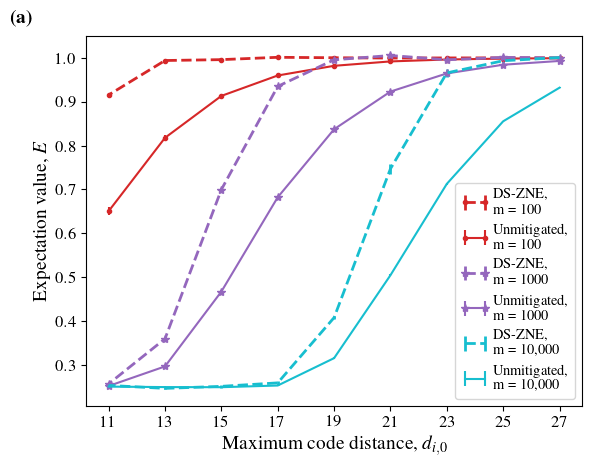

In [25]:
## Plot of expectation values for each set of distances
plt.errorbar(d_array[0:9], ds_exp_vals_depth100[0], yerr=ds_exp_vals_depth100[1], ls='--', color='tab:red', marker='.', label='DS-ZNE,\nm = 100', lw=2)
plt.errorbar(d_array[0:9], exp_vals_depth100[0][0:9], yerr=exp_vals_depth100[1][0:9], color='tab:red', marker='.', label='Unmitigated,\nm = 100')

plt.errorbar(d_array[0:9], ds_exp_vals_depth1000[0], yerr=ds_exp_vals_depth1000[1], ls='--', color='tab:purple', marker='*', label='DS-ZNE,\nm = 1000', lw=2)
plt.errorbar(d_array[0:9], exp_vals_depth1000[0][0:9], yerr=exp_vals_depth1000[1][0:9], color='tab:purple', marker='*', label='Unmitigated,\nm = 1000')

plt.errorbar(d_array[0:9], ds_exp_vals_depth10k[0], yerr=ds_exp_vals_depth10k[1], ls='--', color='tab:cyan', label='DS-ZNE,\nm = 10,000', lw=2)
plt.errorbar(d_array[0:9], exp_vals_depth10k[0][0:9], yerr=exp_vals_depth10k[1][0:9], color='tab:cyan', label='Unmitigated,\nm = 10,000')

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='serif', style='normal', size=10.5)
plt.xlabel(r'Maximum code distance, $d_{i,0}$', family='serif', fontsize=14)
plt.ylabel(r'Expectation value, $E$', family='serif', fontsize=14)
plt.xticks(ticks = d_array.tolist()[0:9][::-1], family='serif', fontsize=12)
plt.yticks(family='serif', fontsize=12)
plt.legend(handletextpad=0.2, prop=font, numpoints=2)
plt.text(7.5, 1.08, r"\textbf{(a)}", weight='bold', fontsize=14, family='serif')
# rc('font', **{'family': 'serif', 'serif': ['Times']})
# rc('text', usetex=False)
plt.savefig("depth_100_1000_10000_ds_unmitigated.eps",format = 'eps', bbox_inches="tight")
plt.show()

In [16]:
def calculate_folding_exp_vals(scale_factors, exp_vals, distance_indices, num_trials):
    """Perform extrapolation to zero noise limit on expectation values obtained
    with noise scaling by unitary folding. Return mean and standard deviation
    of the ZNE expectation values.
    """
    folding_values = np.zeros((num_trials, len(distance_indices)))

    for di in range(len(distance_indices)):
        fac = mitiq.zne.PolyFactory(scale_factors=scale_factors, order=3)
        for trial in range(num_trials):
            folding_values[trial, di] = extrapolate(scale_factors, exp_vals[trial, :, di], fac)

    return [np.mean(folding_values, axis=0), np.std(folding_values, axis=0)]

In [17]:
scale_factors = [1, 3, 5, 7]

raw_folding_depth100 = np.zeros((num_trials, len(scale_factors), len(distance_indices)))
raw_folding_depth1000 = np.zeros((num_trials, len(scale_factors), len(distance_indices)))
raw_folding_depth10k = np.zeros((num_trials, len(scale_factors), len(distance_indices)))

for di in range(len(distance_indices)):
    raw_folding_depth100[:, 0, di] = ds_results_depth100[:, di]
    raw_folding_depth100[:, 1:, di] = np.loadtxt(f"data/folding_depth100_d{d_array[di]}")
    raw_folding_depth1000[:, 0, di] = ds_results_depth1000[:, di]
    raw_folding_depth1000[:, 1:, di] = np.loadtxt(f"data/folding_depth1000_d{d_array[di]}")
    raw_folding_depth10k[:, 0, di] = ds_results_depth10k[:, di]
    raw_folding_depth10k[:, 1:, di] = np.loadtxt(f"data/folding_depth10000_d{d_array[di]}")

folding_depth100 = calculate_folding_exp_vals(scale_factors, raw_folding_depth100, distance_indices, num_trials)
folding_depth1000 = calculate_folding_exp_vals(scale_factors, raw_folding_depth1000, distance_indices, num_trials)
folding_depth10k = calculate_folding_exp_vals(scale_factors, raw_folding_depth10k, distance_indices, num_trials)

WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


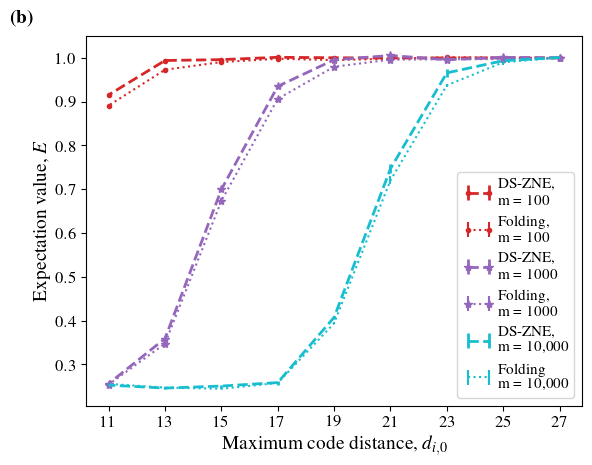

In [33]:
## Plot of expectation values for each set of distances
plt.errorbar(d_array[0:9], ds_exp_vals_depth100[0], yerr=ds_exp_vals_depth100[1], ls='--', color='tab:red', marker='.', label='DS-ZNE,\nm = 100', lw=2)
plt.errorbar(d_array[0:9], folding_depth100[0][0:9], yerr=folding_depth100[1][0:9], ls=':', color='tab:red', marker='.', label='Folding,\nm = 100')

plt.errorbar(d_array[0:9], ds_exp_vals_depth1000[0], yerr=ds_exp_vals_depth1000[1], ls='--', color='tab:purple', marker='*', label='DS-ZNE,\nm = 1000', lw=2)
plt.errorbar(d_array[0:9], folding_depth1000[0][0:9], yerr=folding_depth1000[1][0:9], ls=':', color='tab:purple', marker='*', label='Folding,\nm = 1000')

plt.errorbar(d_array[0:9], ds_exp_vals_depth10k[0], yerr=ds_exp_vals_depth10k[1], ls='--', color='tab:cyan', label='DS-ZNE,\nm = 10,000', lw=2)
plt.errorbar(d_array[0:9], folding_depth10k[0][0:9], yerr=folding_depth10k[1][0:9], ls=':', color='tab:cyan', label='Folding\nm = 10,000')

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='serif', style='normal', size=11)
plt.xlabel(r'Maximum code distance, $d_{i,0}$', family='serif', fontsize=14)
plt.ylabel(r'Expectation value, $E$', family='serif', fontsize=14)
plt.xticks(ticks = d_array.tolist()[0:9][::-1], family='serif', fontsize=12)
plt.yticks(family='serif', fontsize=12)
plt.legend( handletextpad=0.3, prop=font, numpoints=2)
plt.text(7.5, 1.08, r"\textbf{(b)}", weight='bold', fontsize=14, family='serif')
plt.savefig("depth_100_1000_10000_ds_folding.eps",format = 'eps', bbox_inches="tight")
plt.show()

In [24]:
def compare_numerical_results(ds_exp_vals, folding_exp_vals, unmitigated_exp_vals):
    ds_error = np.abs(np.ones((len(ds_exp_vals[0]))) -  ds_exp_vals[0])
    folding_error = np.abs(np.ones_like(folding_exp_vals) - folding_exp_vals)
    unmitigated_mean_vals = np.mean(unmitigated_exp_vals, axis=0)
    unmitigated_error = np.abs(np.ones_like(unmitigated_mean_vals) - unmitigated_mean_vals)
    ds_error_reduction = np.divide((ds_error - unmitigated_error), unmitigated_error)
    folding_error_reduction = np.divide((folding_error - unmitigated_error), unmitigated_error)
    return np.min(ds_error_reduction), np.min(folding_error_reduction)

In [25]:
compare_numerical_results(ds_exp_vals_depth100, folding_depth100[0][0:9], exp_vals_depth100[0][0:9])

(-0.9998201306704956, -0.9939266807736279)

In [26]:
compare_numerical_results(ds_exp_vals_depth1000, folding_depth1000[0][0:9], exp_vals_depth1000[0][0:9])

(-0.9996403521488879, -0.9974202491234001)

In [27]:
compare_numerical_results(ds_exp_vals_depth10k, folding_depth10k[0][0:9], exp_vals_depth10k[0][0:9])

(-0.998534026364001, -0.9987815031841007)